In [1]:
import torch
import torch.nn as nn
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
#from albumentations.pytorch.transforms import ToTensorV2
#from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob


from tqdm import tqdm

from torchvision import transforms, models
import torch.nn.functional as F
import copy

from utilis import visualize, plot_data
from scipy.io import loadmat


SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [2]:
path = '/mnt/home/hheat/USERDIR/counting-bench/data'
train_images = path + '/images'
test_images = path + '/test_images/images'
anno = path + '/annotation'
#density_maps = path + '/dmaps'
sm_train_images = path + '/sm_train_images'
sm_test_images = path + '/sm_test_images'
sm_dmaps = path + '/sm_dmaps'

LOG_PARA = 1000

In [3]:
def get_train_transforms():
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
        ],
)

def get_train_image_only_transforms():
    return A.Compose(
        [
            A.RandomBrightnessContrast(brightness_limit=0.2, 
                                       contrast_limit=0.2, p=0.5),
            A.Blur(blur_limit=3,p=0.2),
        ],
        additional_targets={'image': 'image'}
    )

# def get_valid_trainsforms():
#     return A.Compose(
#         [
#             #A.Resize(360,640,interpolation=2),
#             A.Normalize(mean=mean,std=std,p=1.0,max_pixel_value=1.0),
#             ToTensorV2(p=1.0),
#         ]
#     )

mean = torch.tensor([0.4939, 0.4794, 0.4583])
std = torch.tensor([0.2177, 0.2134, 0.2144])

def denormalize(img):
    img = img * std[...,None,None] + mean[...,None,None]
    img = img.permute(1,2,0).cpu().numpy()
    return img

In [121]:
class Video_Counting_Dataset(Dataset):
    def __init__(self,path,image_fnames,dmap_folder,
                 seq_len=5,gt_folder=None,suffix='jpg',
                 tfms=None,mosaic=False,
                 crop_size=384,method='train',
                 sample=0,segment=5,num_sample=5):
        super().__init__()
        
        self.path = path
        self.image_fnames = image_fnames
        
        # TODO:
        # Be able to get sequences
        self.image_fnames = sorted(self.image_fnames,key=self._split_fn)
        
        self.crop_size = crop_size
        if method not in ['train','valid']:
            raise Exception('Not Implement')
        self.method = method
        self.LOG_PARA = LOG_PARA
        
        self.dmap_folder = path + dmap_folder
        self.seq_len = seq_len
        self.transforms = tfms
        self.mosaic = mosaic
        self.gt_folder = path + gt_folder # test purpose
        self.sample = sample # 0 is consective, 1 is TSN
        self.segment = segment
        self.num_sample = num_sample
        self.mean = np.array([0.485, 0.456, 0.406])
        self.std = np.array([0.229, 0.224, 0.225])
        self.item_tfms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=self.mean,std=self.std),
        ])
        
    def __len__(self):
        return len(self.image_fnames)
    
    def _split_fn(self,f):
        f = f.split('/')[-1].split('.')[0]
        return int(f[3:5]),int(f[-3:])
    
    def __getitem__(self, idx):
        '''
            Get a sequence of frames
            Return: 
                frames, shape: seq, h,w,c
                dmaps, shape: seq, h,w
                gt_points, seq_len of each frame
        '''
        if self.sample: # TSN sampling
            frames,dmaps,fns,gt_points = self._tsn_sampling(idx)
        else:
            frames,dmaps,fns,gt_points = self._consective_sampling(idx)
            
        h,w = frames.shape[-2], frames.shape[-1]
        
        if self.method == 'train':
            i,j = self._random_crop(h,w,self.crop_size,self.crop_size)
            frames = frames[:,:,i:i+self.crop_size,j:j+self.crop_size]
            dmaps = dmaps[:,i:i+self.crop_size,j:j+self.crop_size]
            
#             import pdb
#             pdb.set_trace()
            for idx in range(len(gt_points)):
                gt_points[idx] = [p_l - [j,i] for p_l in gt_points[idx]]
                mask = [(p[:,0]>=0) * (p[:,0]<=self.crop_size) * (p[:,1]>=0) * (p[:,1]<=self.crop_size) for p in gt_points[idx]]
                gt_points[idx] = [gt_p[m] for gt_p, m in zip(gt_points[idx],mask)]
            
#             gt_points = gt_points - [j,i]
#             mask = (gt_points[:,0] >=0 ) * (gt_points[:,0] <= self.crop_size) * (gt_points[:,1]>=0) * (gt_points[:,1]<=self.crop_size)
#             gt_points = gt_points[mask]
#             density_map = cv2.resize(density_map,(self.crop_size//self.downsample,self.crop_size//self.downsample))
            
            
        if not isinstance(self.transforms,type(None)):
            t,ch,h,w = frames.shape
            frames = frames.view(t*ch,h,w).permute(1,2,0).numpy()
            dmaps = dmaps.permute(1,2,0).numpy()
            for tfms in self.transforms:
                aug = tfms(**{
                    'image': frames,
                    'mask': dmaps
                })
                frames, dmaps = aug['image'], aug['mask']
                
            frames = torch.from_numpy(frames).permute(2,0,1).view(t,ch,h,w)
            dmaps = torch.from_numpy(dmaps).permute(2,0,1)
        return frames, dmaps*self.LOG_PARA, fns, gt_points
    
    def _tsn_sampling(self,idx):
        '''
        Note:
        This method broadly corresponds to the frame sampling technique
        introduced in ``Temporal Segment Networks`` at ECCV2016
        https://arxiv.org/abs/1608.00859.
        
        Note: 
        Minor changes:
        1) When frames don't have enough to sample, resample at the given region until we reach segments
            pitfall: if last idx is passed, then tsn sampling will duplicate segment times of last frame
        2) offset index when we have enough frames
        
        Args: 
            idx: call by __getitem__
        
        Returns:
            List of frames sampled in tensor
            List of density maps sampled in tensor
            List of file names
            List of point annotation
        '''
        frames, d_maps, fns, gt_points = [],[],[],[]
        length = self.segment * self.num_sample
        start_frame = idx
        
        end_idx = ((idx // 350) + 1) * 350 - 1
        if end_idx > self.__len__() - 1:
            end_idx = self.__len__() - 1
        # Edge case when we don't have enough to sample, result repeated frames
        if start_frame + length > end_idx:
            idxs = np.sort(np.random.randint(start_frame,end_idx+1,self.segment))
        
        # Sample segment times, sampling gap equals to num_sample
        else:
            end_frame = start_frame + length - 1
            idxs = (np.arange(start_frame,end_frame+1,self.num_sample)
                    + np.random.randint(self.num_sample,size=self.segment))
        for idx in idxs:
            fn = self.image_fnames[idx]
            image,dmap,points = self._load_one_frame(fn)
            frames.append(image)
            d_maps.append(dmap)
            fns.append(fn)
            gt_points.append(points)
        return torch.stack(frames),torch.stack(d_maps),fns,np.array(gt_points)
    
    def _consective_sampling(self,idx):
        '''
        Choose consective frames from given positin idx
        
        Args:
            idx: call by __getitem__
            
        Returns:
            List of frames sampled in tensor
            List of density maps sampled in tensor
            List of file names
            List of point annotation
        '''
        frames, d_maps, fns, gt_points = [],[],[],[]
        
        end_idx = ((idx // 350) + 1) * 350 - 1
        
        frame_diff = end_idx - idx
        if frame_diff >= self.seq_len:
            start_frame = idx
        elif frame_dff < self.seq_len:
            # random back off when sampling dont have enough samples
            idx -= frame_diff
            start_frame = round((idx - frame_diff) * np.random.rand())
        else:
            raise ValueError('start_frame init error...')
        for n in range(idx,idx+self.seq_len):
                fn = self.image_fnames[n]
                image,dmap,points = self._load_one_frame(fn)
                frames.append(image)
                d_maps.append(dmap)
                fns.append(fn)
                gt_points.append(points)
        
        return torch.stack(frames),torch.stack(d_maps),fns,np.array(gt_points)
    
    def _load_one_frame(self,fn):
        y_fn, p_fn = self._prepare_fn(fn)
        image = cv2.imread(fn)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
        image = image/255.
        image = self.item_tfms(image)
        d_map, points = self._get_gts(y_fn,p_fn)
        d_map = torch.from_numpy(d_map)
        return image, d_map, points
    
    def _prepare_fn(self,fn):
        file_name = fn.split('/')[-1].split('.')[0]
        y_fn = self.dmap_folder + '/' + file_name + '.npy'
        p_fn = self.gt_folder + '/' + file_name[3:] + '.mat'
        return y_fn, p_fn
    
    def _get_gts(self,y_fn,p_fn):
        d_map = np.load(y_fn,allow_pickle=True)
        if not self.gt_folder:
            return (None,0)
        test_data = loadmat(p_fn)
        points = test_data['annotation'].astype(int)
        return d_map, points
    
    def _random_crop(self, im_h, im_w, crop_h, crop_w):
        res_h = im_h - crop_h
        res_w = im_w - crop_w
        i = random.randint(0, res_h)
        j = random.randint(0, res_w)
        return i, j
    
    def _normalize(self,img):
        img -= self.mean[None,None,...]
        img /= self.std[None,None,...]
        return img

In [119]:
train_dataset = Video_Counting_Dataset(path=path, image_fnames=glob(sm_train_images+'/*.jpg'),
                                       dmap_folder='/sm_dmaps',
                                       gt_folder='/annotation',
                                       #tfms=[get_train_transforms(),get_train_image_only_transforms()],
                                       sample=1, crop_size=456,method='train'
)
valid_dataset = Video_Counting_Dataset(path=path, image_fnames=glob(sm_test_images+'/*.jpg'),
                                       dmap_folder='/sm_dmaps',
                                       gt_folder='/annotation',
                                       sample=1, method='valid'#, segment=1
)

In [120]:
imgs,dmaps,fns,gt_points = train_dataset[0]

IndexError: too many indices for array

In [108]:
dmaps.sum(dim=[-1,-2]) / 1000

tensor([25.0297, 30.8838, 28.1448, 34.2074, 26.1064])

In [109]:
[len(p) for p in gt_points]

[0, 0, 0, 0, 0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


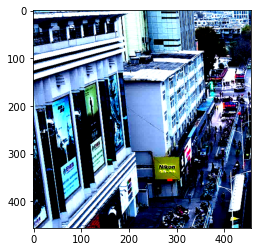

In [111]:
plt.imshow(imgs[0].permute(1,2,0).numpy())

In [112]:
import PIL



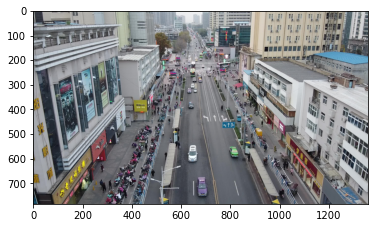

In [113]:
img = PIL.Image.open(fns[0])
plt.imshow(img)

In [49]:
i,j = (1000, 500)

In [50]:
points = [p_l - [j,i] for p_l in gt_points]

In [51]:
mask = [(p[:,0]>=0) * (p[:,0]<=1024) * (p[:,1]>=0) * (p[:,1]<=1024) for p in points]

In [52]:
mask

[array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False, False, False, False, False,  True,
         True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False, False, False,  True,  True,  True,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, Fal

In [25]:
len(loadmat(anno+'/01_015.mat')['annotation'])

63

In [26]:
fns[2]

'/mnt/home/hheat/USERDIR/counting-bench/data/sm_train_images/sm_01_015.jpg'

In [7]:
class TrainGlobalConfig:
    num_workers = 16
    batch_size = 8
    n_epochs = 30 
    lr = 0.0002

    folder = 'test_delete'
    downsample = 1
    split_num = 2

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = True  # do scheduler.step after optimizer.step
    validation_scheduler = False  # do scheduler.step after validation stage loss

    SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
    scheduler_params = dict(
        max_lr=1e-3,
        #total_steps = len(train_dataset) // 4 * n_epochs, # gradient accumulation
        epochs=n_epochs,
        steps_per_epoch=int(len(train_dataset) / batch_size),
        pct_start=0.3,
        anneal_strategy='cos', 
        final_div_factor=10**5
    )
    
#     SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
#     scheduler_params = dict(
#         mode='min',
#         factor=0.5,
#         patience=1,
#         verbose=False, 
#         threshold=0.0001,
#         threshold_mode='abs',
#         cooldown=0, 
#         min_lr=1e-8,
#         eps=1e-08
#     )

# Model

In [8]:
# if two parts are jointly trained, use fastVCC.
class fastVCC(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, len_frames=3):
        super(fastVCC, self).__init__()
        self.len_frames = len_frames
        self.lcn = LCN(in_channels=3, out_channels=1)
        self.drbs = DRBs(num_stages=3, num_layers=3, num_f_maps=5, in_channels=self.len_frames, out_channels=self.len_frames)

    def forward(self, x):
        """
        :param x: input of multiple frames
                  (N, F, C, Hin, Win), N=batch size, F= the length of frames
        :return:
                lcn_outputs: output from LCN, (N, F, Cout, Hout, Wout) Cout=1, Hout=Hin/8, Wout=Win/8
                count_outputs：output from counting layer of each DRB block,
                               (num_stages, N, Cout, Hout, Wout), Cout=1, Hout=Hin/8, Wout=Win/8

        """
        assert self.len_frames == x.shape[1]
        for i in range(self.len_frames):
            lcn_out = self.lcn(x[:, i, :, :, :])  # (N, Cout, Hout, Wout)
            if i == 0:
                lcn_outputs = lcn_out.unsqueeze(1)
            else:
                lcn_outputs = torch.cat((lcn_outputs, lcn_out.unsqueeze(1)), dim=1)     # (N, F, Cout, Hout, Wout)

        # reshape and concatenate
        drbs_input = torch.reshape(lcn_outputs, (lcn_outputs.shape[0], lcn_outputs.shape[1], -1))   # (N, F, Cout*Hout*Wout) Cout=1
        drbs_output = self.drbs(drbs_input)     # (num_stages, N, F, Hout*Wout)

        # normalization to get weights
        l1norm = torch.sum(torch.abs(drbs_output), dim=-1)     # (num_stages, N, F)
        weights = l1norm/l1norm.sum(dim=-1, keepdim=True)     # (num_stages, N, F)

        # counting layer
        count_outputs = lcn_outputs.unsqueeze(0) * weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)     # (num_stages, N, Cout, Hout, Wout)

        return lcn_outputs, count_outputs



class LCN(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, load_weights=False):
        super(LCN, self).__init__()
        self.channels_cfg = [8, 'M', 16, 16, 'M', 32, 32, 32, 'M', 16, 8]
        self.lcn = make_layers(self.channels_cfg, in_channels)
        self.output_layer = nn.Conv2d(8, out_channels, kernel_size=1)
        if not load_weights:
            self._initialize_weights()

    def forward(self, x):
        """
        :param x: input: a single frame, (N, Cin, H, W)
        :return: x: the output size is 1/8 of original input size, (N, Cout, Hout, Wout)
        """
        x = self.lcn(x)
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


class DRBs(nn.Module):
    # def __init__(self, num_stages=3, num_layers=3, num_f_maps=5, in_channels=5, out_channels=5, load_weights=False):
    def __init__(self, num_stages=3, num_layers=3, num_f_maps=5, in_channels=5, out_channels=5):
        """
        :param num_stages: the number of DRB block, default 3
        :param num_layers: the number of DilatedResidualLayer, default 3
        :param num_f_maps: the number of medium feature_maps
        :param in_channels: should be the length of frames per input, default 5
        :param out_channels: should be equal to in_channels, default 5
        """
        super(DRBs, self).__init__()
        self.stage1 = DRB(num_layers, num_f_maps, in_channels, out_channels)
        self.stages = nn.ModuleList([copy.deepcopy(DRB(num_layers, num_f_maps, out_channels, out_channels)) for s in range(num_stages-1)])
        # if not load_weights:
        #     self._initialize_weights()

    def forward(self, x):
        """
        :param x: tensor after reshape and concatenation of LCN outputs
                  (N, F, H*W), F represent the length of frames
        :return: outputs of each DRB stage
                  (num_stages, N, F, H*W)
        """
        out = self.stage1(x)
        outputs = out.unsqueeze(0)
        for s in self.stages:
            out = s(out)
            outputs = torch.cat((outputs, out.unsqueeze(0)), dim=0)
        return outputs

    # def _initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Conv1d):
    #             nn.init.normal_(m.weight, std=0.01)
    #             if m.bias is not None:
    #                 nn.init.constant_(m.bias, 0)
    #         elif isinstance(m, nn.BatchNorm1d):
    #             nn.init.constant_(m.weight, 1)
    #             nn.init.constant_(m.bias, 0)


class DRB(nn.Module):
    def __init__(self, num_layers, num_f_maps, in_channels, out_channels):
        super(DRB, self).__init__()
        self.conv_1x1 = nn.Conv1d(in_channels, num_f_maps, 1)
        self.layers = nn.ModuleList([copy.deepcopy(DilatedResidualLayer(2 ** i, num_f_maps, num_f_maps)) for i in range(num_layers)])
        self.conv_out = nn.Conv1d(num_f_maps, out_channels, 1)

    def forward(self, x):
        out = self.conv_1x1(x)
        for layer in self.layers:
            out = layer(out)
        out = self.conv_out(out)
        return out


class DilatedResidualLayer(nn.Module):
    def __init__(self, dilation, in_channels, out_channels):
        super(DilatedResidualLayer, self).__init__()
        self.conv_dilated = nn.Conv1d(in_channels, out_channels, 3, padding=dilation, dilation=dilation)
        self.conv_1x1 = nn.Conv1d(out_channels, out_channels, 1)
        # self.dropout = nn.Dropout()

    def forward(self, x):
        out = F.relu(self.conv_dilated(x))
        out = self.conv_1x1(out)
        # out = self.dropout(out)   # TODO: use dropout?
        return (x + out)


def make_layers(cfg, in_channels=3, batch_norm=False, dilation=False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

# Test

In [9]:
model = fastVCC(len_frames=5).cuda()

In [10]:
def collate_fn(batch):
    frames, dmaps, fns, gt_points = zip(*batch)
    return torch.stack(frames), torch.stack(dmaps), fns, gt_points

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=TrainGlobalConfig.batch_size,
    sampler=RandomSampler(train_dataset),
    pin_memory=False,
    drop_last=True,
    num_workers=TrainGlobalConfig.num_workers,
    collate_fn=collate_fn,
)

val_loader = torch.utils.data.DataLoader(
    valid_dataset, 
    batch_size=TrainGlobalConfig.batch_size,
    num_workers=TrainGlobalConfig.num_workers,
    shuffle=False,
    sampler=SequentialSampler(valid_dataset),
    pin_memory=False,
    collate_fn=collate_fn,
)


In [72]:
imgs, dmaps, fns, gt_points = next(iter(train_loader))

In [27]:
model.eval()
with torch.no_grad():
    preds = model(imgs.cuda())
preds[0].shape,preds[1].shape

(torch.Size([8, 5, 1, 57, 57]), torch.Size([3, 8, 5, 1, 57, 57]))

In [28]:
preds[0].sum(dim=[-1,-2,-3]) * 64

tensor([[-1.1785e-05, -1.1905e-05, -1.1922e-05, -1.1889e-05, -1.1960e-05],
        [-8.1637e-06, -8.1186e-06, -8.0900e-06, -8.0848e-06, -8.0470e-06],
        [-3.2105e-06, -3.2705e-06, -3.2617e-06, -3.2449e-06, -3.2792e-06],
        [-4.6885e-06, -4.6885e-06, -4.6812e-06, -4.6494e-06, -4.6647e-06],
        [-9.3012e-06, -9.3176e-06, -9.3020e-06, -9.3690e-06, -9.2841e-06],
        [-4.4724e-06, -4.4407e-06, -4.5041e-06, -4.4831e-06, -4.4667e-06],
        [-1.2179e-06, -1.2440e-06, -1.2055e-06, -1.2769e-06, -1.2840e-06],
        [-1.0583e-05, -1.0470e-05, -1.0482e-05, -1.0570e-05, -1.0581e-05]],
       device='cuda:0')

In [29]:
preds[1][-1].sum(dim=[-1,-2,-3]) * 64

tensor([[-2.6783e-06, -3.8281e-06, -4.4689e-07, -3.5844e-06, -1.3418e-06],
        [-1.8554e-06, -2.6107e-06, -3.0326e-07, -2.4374e-06, -9.0283e-07],
        [-7.2964e-07, -1.0517e-06, -1.2227e-07, -9.7828e-07, -3.6791e-07],
        [-1.0656e-06, -1.5077e-06, -1.7548e-07, -1.4017e-06, -5.2336e-07],
        [-2.1139e-06, -2.9962e-06, -3.4869e-07, -2.8246e-06, -1.0416e-06],
        [-1.0164e-06, -1.4280e-06, -1.6884e-07, -1.3516e-06, -5.0114e-07],
        [-2.7678e-07, -4.0002e-07, -4.5188e-08, -3.8498e-07, -1.4405e-07],
        [-2.4052e-06, -3.3669e-06, -3.9292e-07, -3.1866e-06, -1.1872e-06]],
       device='cuda:0')

In [73]:
[len(p) for p in gt_points[0]]

[0, 0, 1, 0, 0]

In [74]:
dmaps[0].sum(dim=[-1,-2]) / 1000

tensor([10.6317, 23.4320, 23.7592, 16.7137, 25.5563])

In [76]:
fns[0][0]

'/mnt/home/hheat/USERDIR/counting-bench/data/sm_train_images/sm_02_024.jpg'

In [78]:
import PIL

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


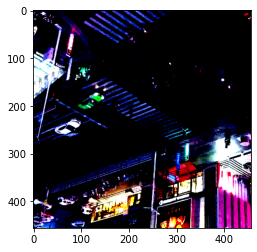

In [82]:
plt.imshow(imgs[0][0].permute(1,2,0).numpy())